In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar
from dask.distributed import Client
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
from utils import beaker_to_xarray

In [2]:
Client()

<Client: 'tcp://127.0.0.1:35837' processes=4 threads=8, memory=29.37 GiB>

In [3]:
beaker_dataset_id = '01J9Q604XQ1YPCPC9SRJQWBQ8A'
era5_url = 'gs://vcm-ml-intermediate/2024-06-20-era5-1deg-8layer-1940-2022.zarr'
start_year = '1990'
end_year = '2019'

In [4]:
ds_era5 = xr.open_zarr(era5_url)
ds_era5['PRATEsfc'] = (86400 * ds_era5['PRATEsfc']).assign_attrs(units='mm/day')

In [5]:
variables = ['TMP2m', 'PRATEsfc', 'ULWRFtoa', 'USWRFtoa', 'UGRD10m', 'eastward_wind_3', 'air_temperature_0', 'specific_total_water_0', ]

In [6]:
with ProgressBar():
    ds_era5_mean = ds_era5[variables].sel(time=slice(start_year, end_year)).mean(dim='time').compute()

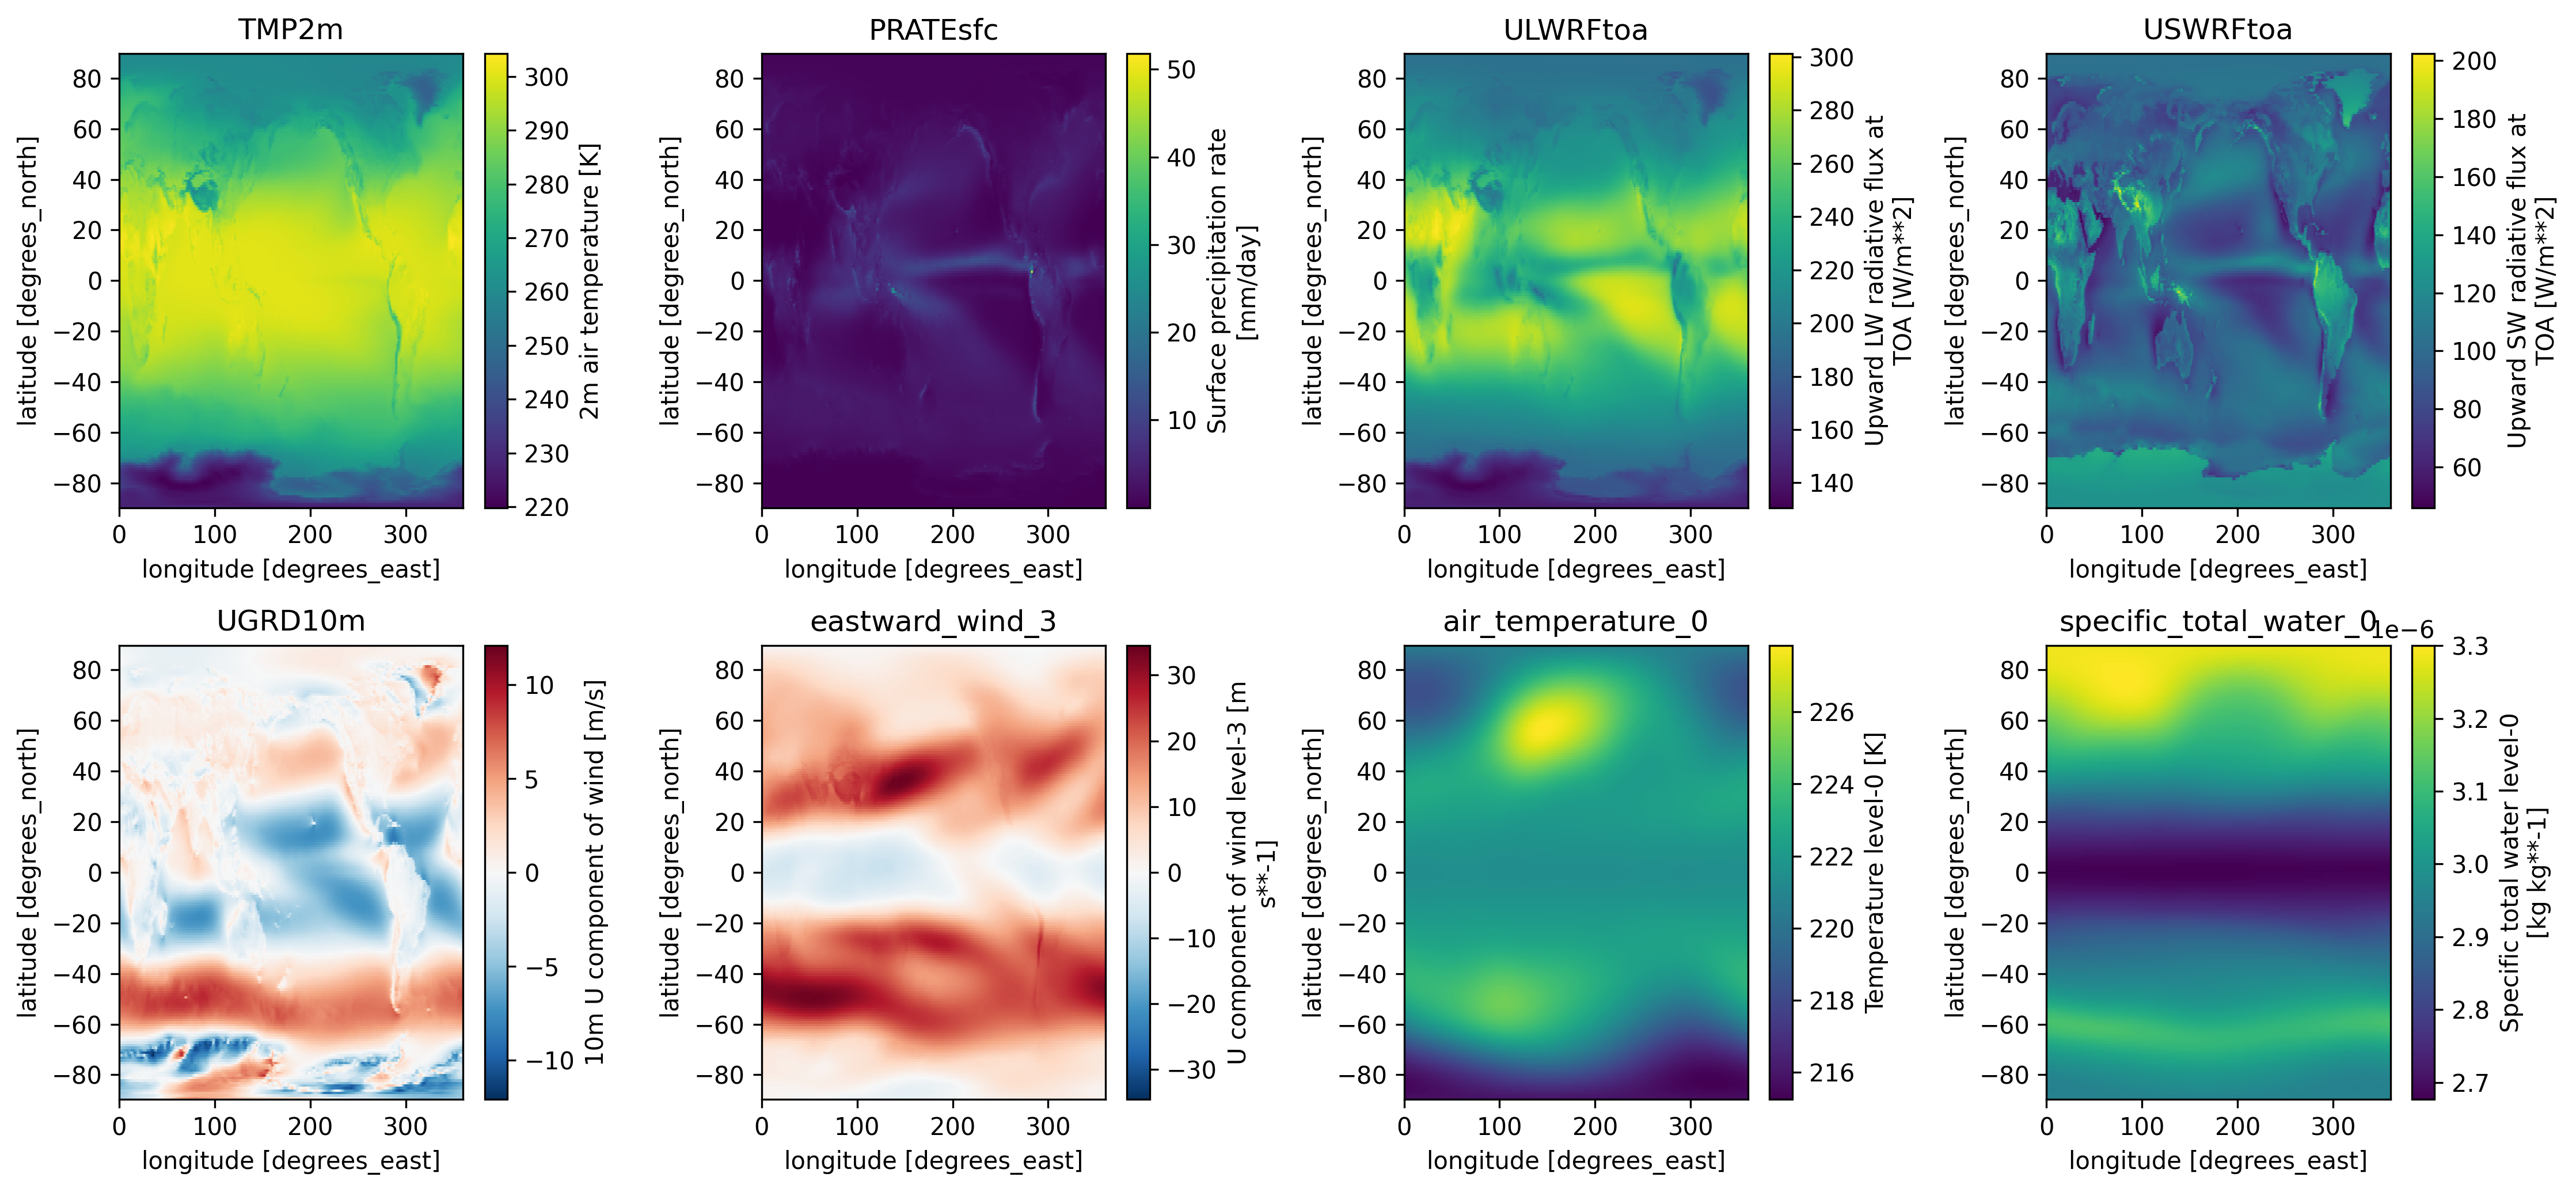

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flat
for i, var in enumerate(variables):
    ds_era5_mean[var].plot(ax=axes[i])
    axes[i].set_title(var)
fig.tight_layout()

In [8]:

rename = {f"gen_map-{var}": var for var in variables}
coord_rename = {'lat': 'latitude', 'lon': 'longitude'}

def get_time_mean(beaker_dataset_id, segment_number, latitude):
    ds = beaker_to_xarray(beaker_dataset_id, f"segment_{segment_number:04}/time_mean_diagnostics.nc")
    ds = ds.rename(rename)
    ds = ds.rename(coord_rename)
    ds = ds[variables]
    ds['latitude'] = latitude
    ds['PRATEsfc'] = (86400 * ds['PRATEsfc']).assign_attrs(units='mm/day')
    return ds

In [9]:
ds_ace2 = []
for segment_number in range(10):
    ds = get_time_mean(beaker_dataset_id, segment_number, ds_era5.latitude)
    ds = ds.assign_coords(segment=segment_number)
    ds_ace2.append(ds)

ds_ace2 = xr.concat(ds_ace2, dim='segment')

/home/OliWM/miniconda3/envs/ace2-paper/lib/python3.10/site-packages/beaker/client.py:163: UserWarning: You're using beaker-py v1.31.3, but a newer version (v1.32.0) is available.

Please upgrade with `pip install --upgrade beaker-py`.

You can find the release notes for v1.32.0 at https://github.com/allenai/beaker-py/releases/tag/v1.32.0

  warnings.warn(


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

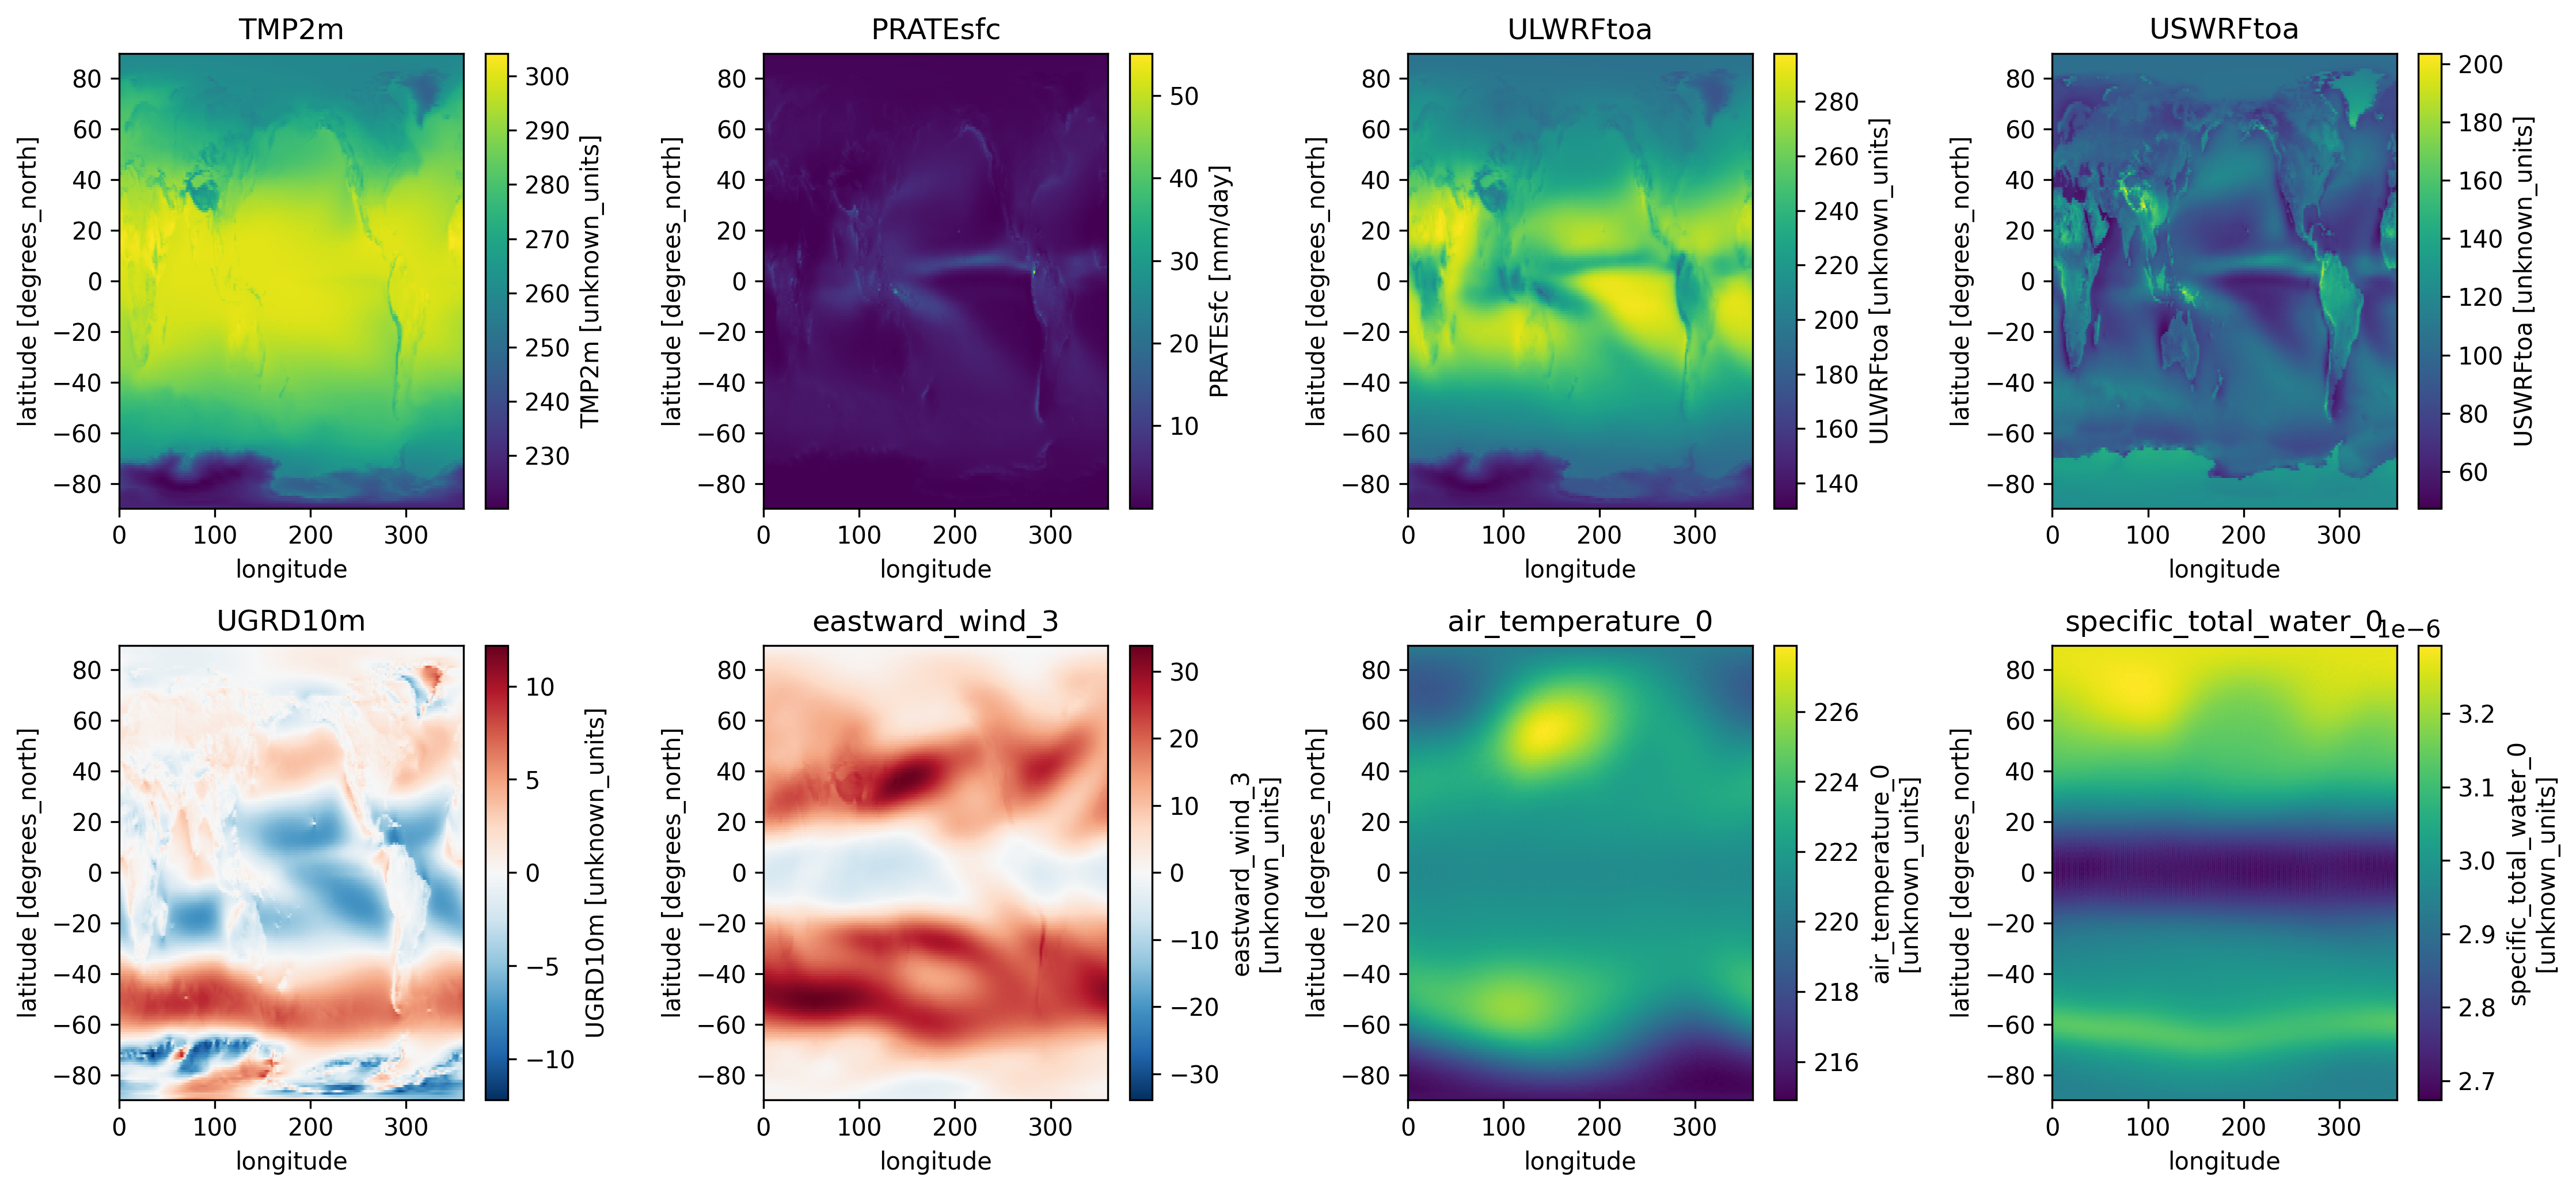

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7))
axes = axes.flat
for i, var in enumerate(variables):
    ds_ace2.isel(segment=0)[var].plot(ax=axes[i])
    axes[i].set_title(var)
fig.tight_layout()

In [12]:
ds_ace2_bias = ds_ace2 - ds_era5_mean
for name in ds_ace2_bias:
    ds_ace2_bias[name].attrs = ds_era5_mean[name].attrs

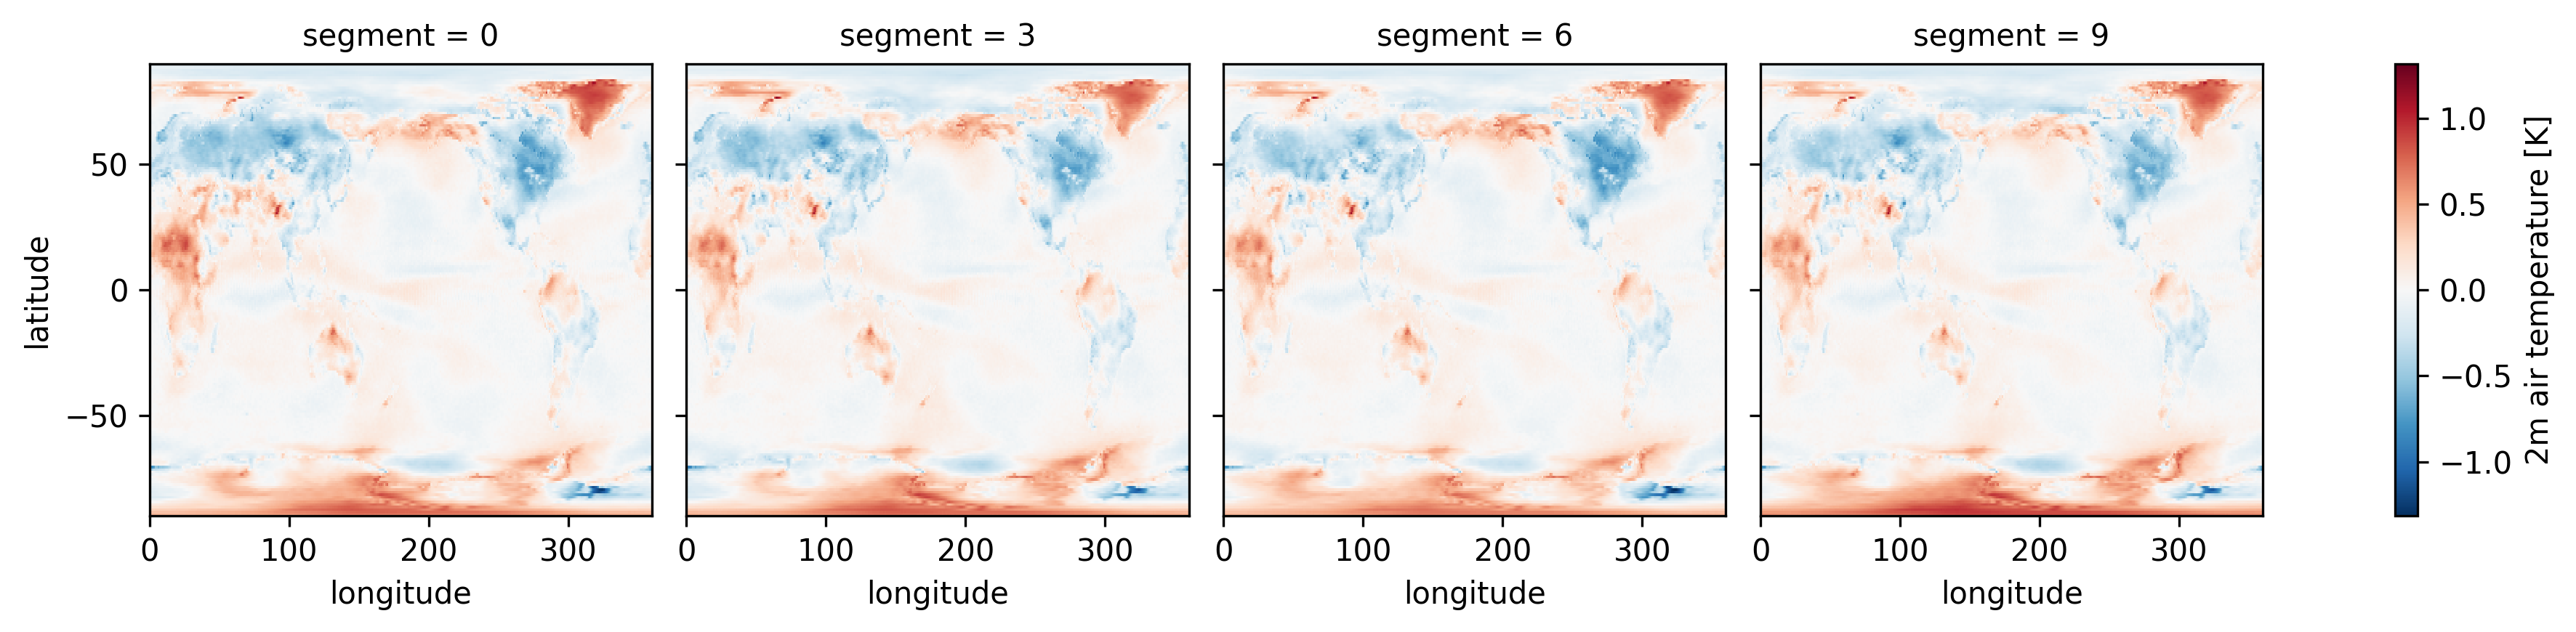

In [15]:
ds_ace2_bias.TMP2m.isel(segment=[0, 3, 6, 9]).plot(col='segment')

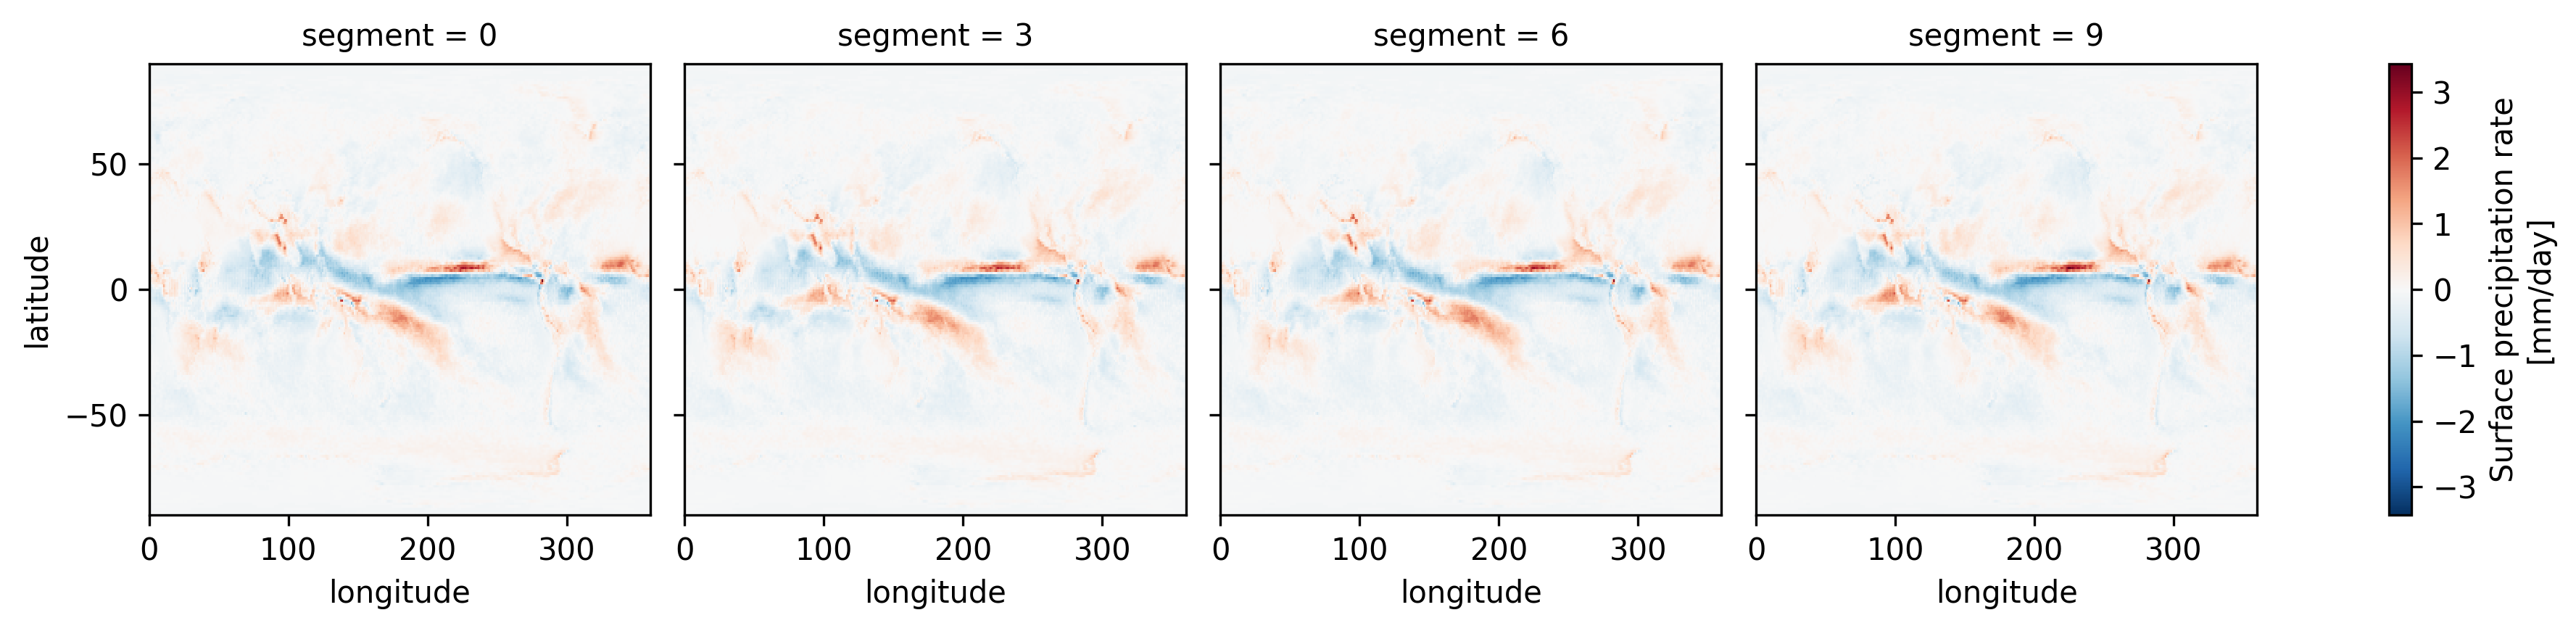

In [16]:
ds_ace2_bias.PRATEsfc.isel(segment=[0, 3, 6, 9]).plot(col='segment')

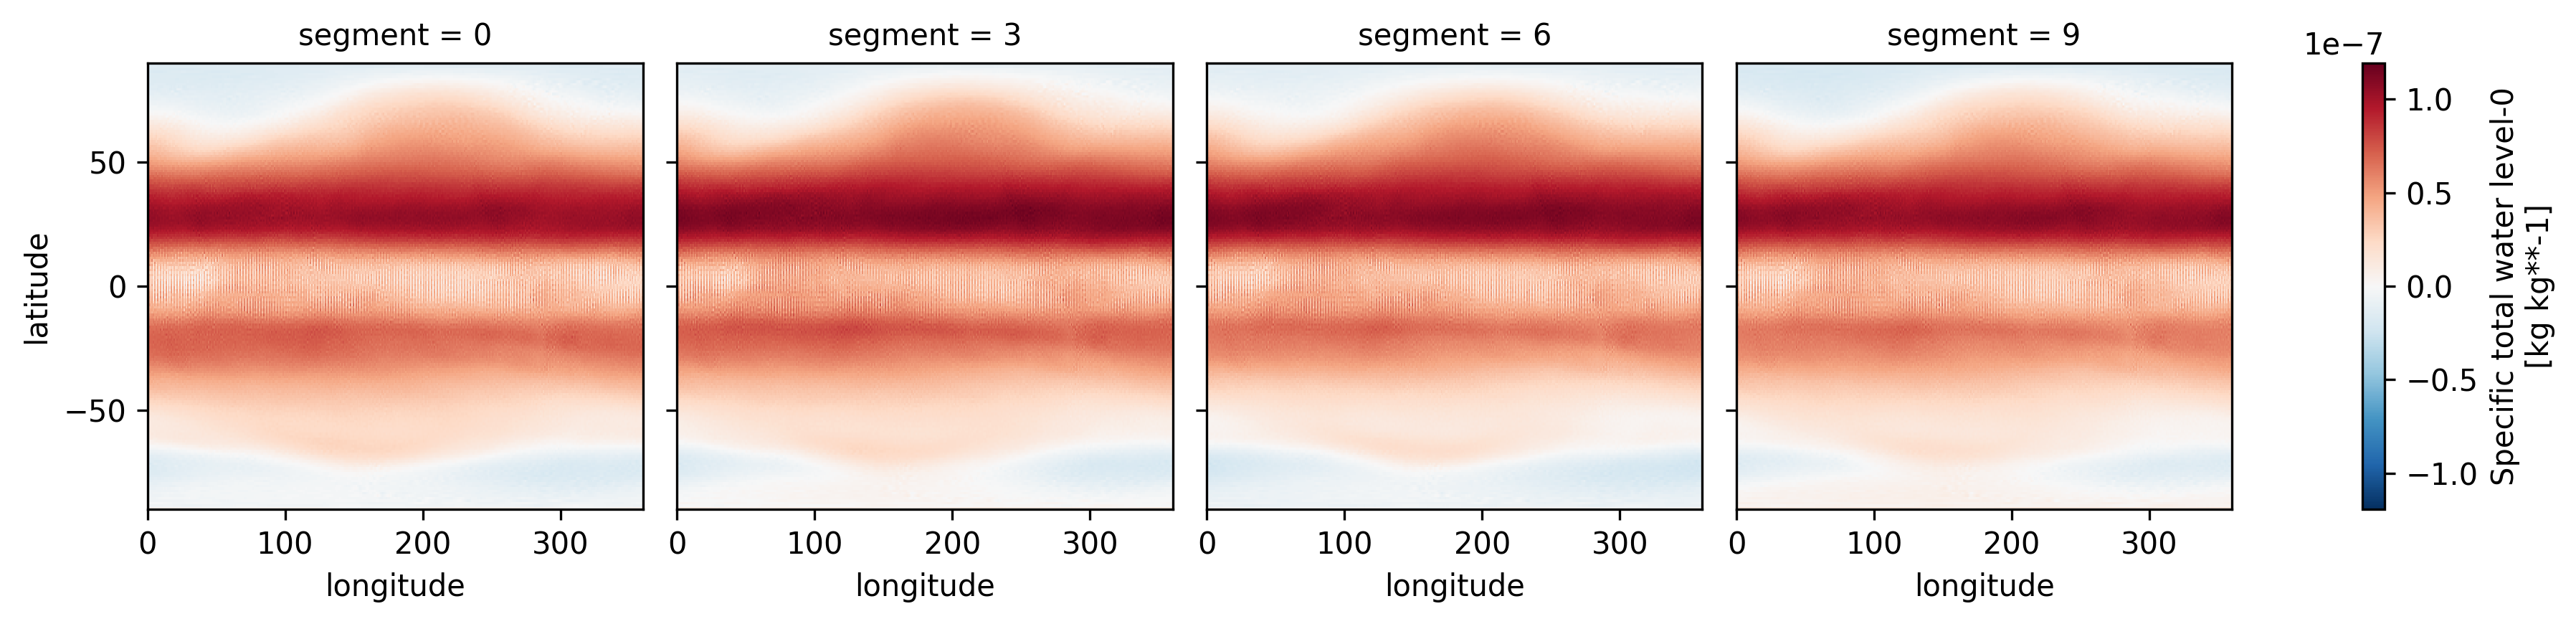

In [17]:
ds_ace2_bias.specific_total_water_0.isel(segment=[0, 3, 6, 9]).plot(col='segment')

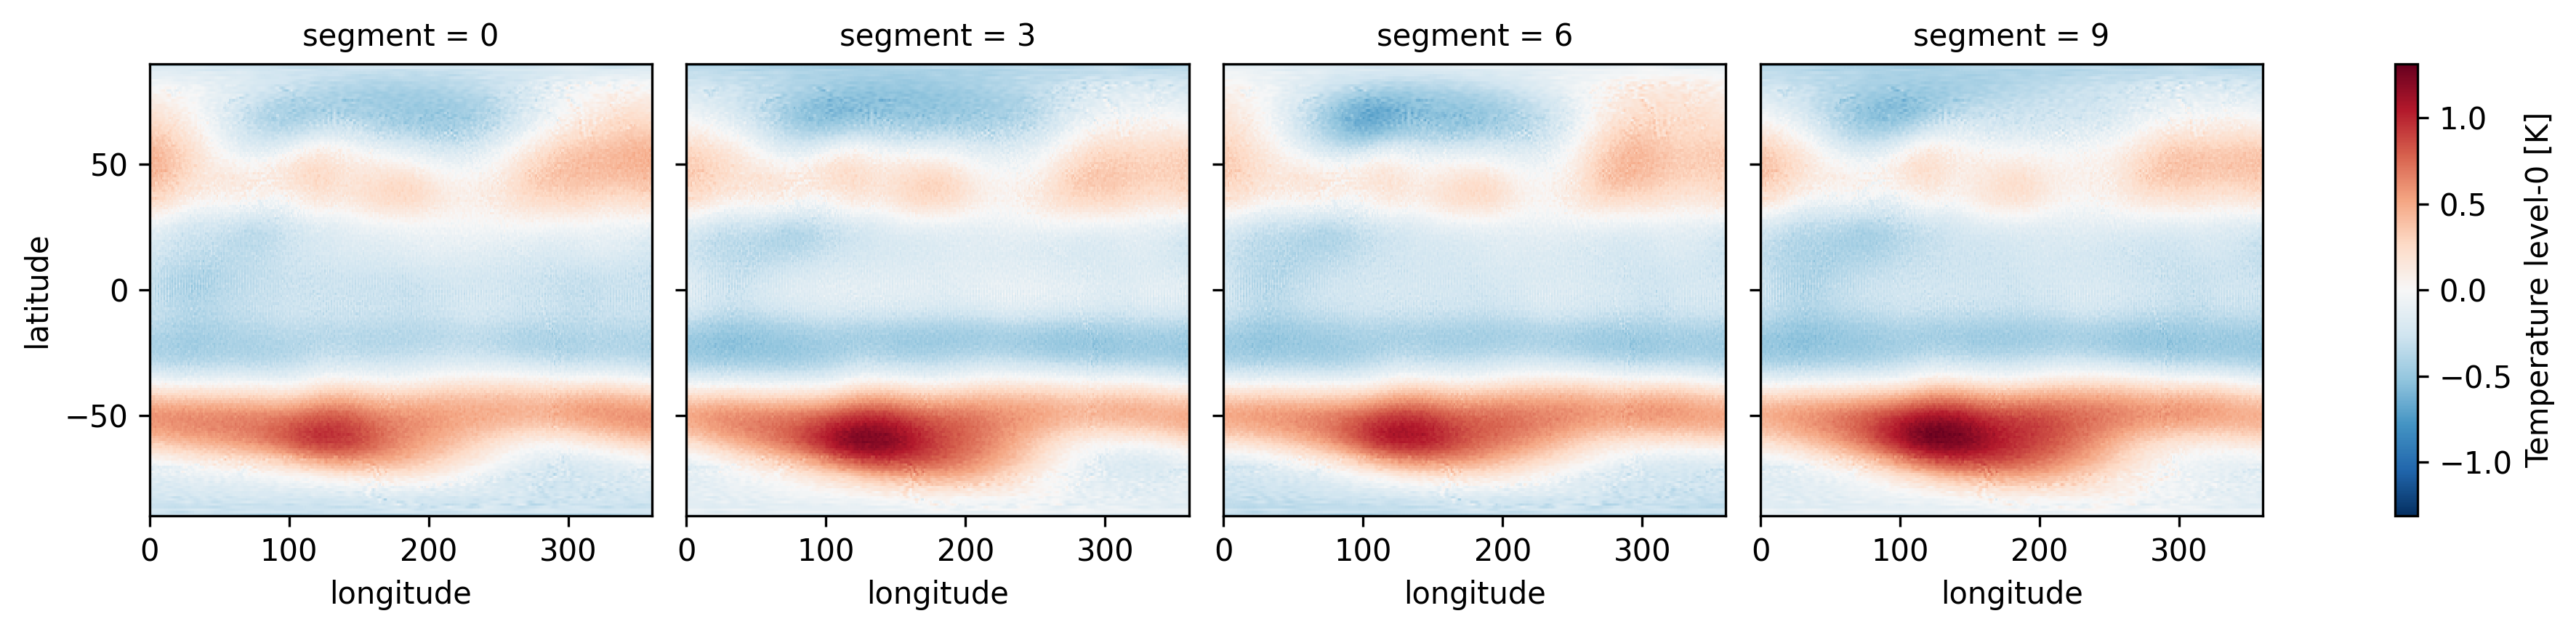

In [18]:
ds_ace2_bias.air_temperature_0.isel(segment=[0, 3, 6, 9]).plot(col='segment')